In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=5, suppress=True) 
import matplotlib.pyplot as plt
import re
import sqlite3
%matplotlib inline
pd.options.display.max_columns = 100
import seaborn as sb
import datetime
from sqlalchemy import create_engine
from difflib import SequenceMatcher, get_close_matches
from IPython.core.display import HTML
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score
from ipywidgets import widgets
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/

In [2]:
from sklearn import datasets
houseprices_raw = datasets.load_boston()
print(houseprices_raw['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
# Create dataframe
houseprices_df = pd.DataFrame(data = houseprices_raw['data'], columns = houseprices_raw['feature_names'])
houseprices_df['target'] = houseprices_raw['target']
houseprices_df.sample()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
446,6.28807,0.0,18.1,0.0,0.74,6.341,96.4,2.072,24.0,666.0,20.2,318.01,17.79,14.9


Lin model intercept: -34.67, slope: 9.10
R square: 48.4
MSE: 43.60


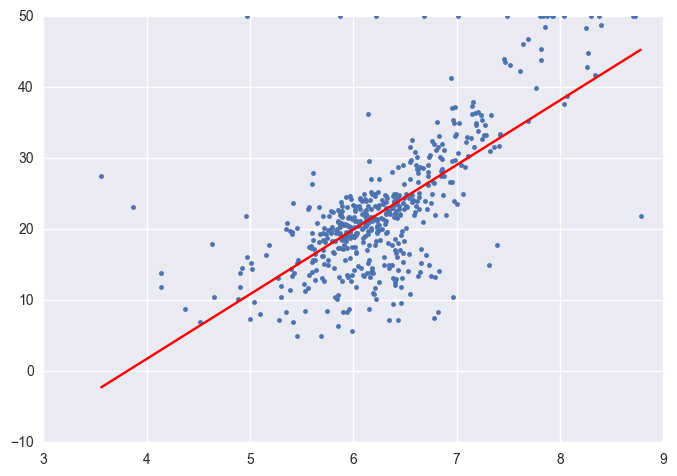

In [4]:
from sklearn.linear_model import LinearRegression
# Correlation between number of rooms and price
lin_model = LinearRegression(fit_intercept=True)
lin_model_fitted = lin_model.fit(X=houseprices_df[['RM']], y=houseprices_df['target'])
plt.plot(houseprices_df['RM'], houseprices_df['target'], '.')
plt.plot([houseprices_df['RM'].min(), houseprices_df['RM'].max()],
         [lin_model_fitted.intercept_ + (houseprices_df['RM'].min() * lin_model_fitted.coef_[0]), 
          lin_model_fitted.intercept_ + (houseprices_df['RM'].max() * lin_model_fitted.coef_[0])], 
         'r-')
print('Lin model intercept: {:.2f}, slope: {:.2f}'.format(lin_model_fitted.intercept_, lin_model_fitted.coef_[0]))
print('R square: {:.1f}'.format(lin_model_fitted.score(X=houseprices_df[['RM']], y=houseprices_df['target'])*100))
y_hat = lin_model_fitted.predict(houseprices_df[['RM']])
y = houseprices_df['target']
n = len(y)
print('MSE: {:.2f}'.format(np.sum(np.square(y-y_hat))/n))

The gradient descent can be combined with a line search, finding the locally optimal step size γ {\displaystyle \gamma } \gamma on every iteration. Performing the line search can be time-consuming. Conversely, using a fixed small γ {\displaystyle \gamma } \gamma can yield poor convergence.

In [194]:
# Gradient descent
def gradient_desc(X, y, learn_rate=0.01, conv_treshold=0.1, max_iter=10):
    MSE_interations = []
    n = len(y)
    # Initialize linear regression coefficients
    slope = 0
    intercept = 0
    # First prediction
    y_hat = intercept + X*slope
    MSE = np.sum(np.square(y-y_hat))/n
    MSE_interations.append(MSE)
    print('Initial MSE {:.2f}'.format(MSE))
    converged = False
    iterations = 0
    while not converged:
        #print('Iteration : {}'.format(iterations))
        slope -= learn_rate * (-2/n)*np.sum((y-y_hat) * X)
        intercept -=  learn_rate * ((-2/n)*np.sum(y-y_hat))
        #print('New slope: {:.2f} and intercept : {:.2f}'.format(slope, intercept))
        y_hat = intercept + X*slope
        MSE_new = np.sum(np.square(y-y_hat))/n
        MSE_interations.append(MSE_new)
        #print('New MSE {:.2f}'.format(MSE_new))
        if(np.abs(MSE_new - MSE) <= conv_treshold):
            plt.plot(MSE_interations)
            print('Optimal intercept : {:.2f}, optimal slope {:.2f}, MSE {:.2f} after {} iterations'.format(intercept, slope, MSE, iterations))
            converged = True
            return intercept, slope, MSE_new
        
        iterations += 1
        MSE = MSE_new
        if(iterations > max_iter):
            plt.plot(MSE_interations)
            converged  = True
            print('Max iterations done, returning intercept: {:.2f} and slope: {:.2f}, MSE {:.2f} after {} iterations'.format(intercept, slope, MSE, iterations))
            return intercept, slope, MSE_new
    

Initial MSE 592.15
Optimal intercept : -34.38, optimal slope 9.06, MSE 43.60 after 9974 iterations


(-34.380266583091, 9.0564638299811442, 43.601590479538359)

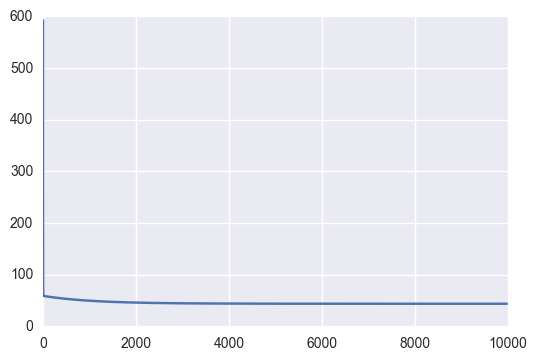

In [195]:
gradient_desc(X = houseprices_df['RM'].values, y = houseprices_df['target'].values, 
              learn_rate=0.02, 
              max_iter=10000, 
              conv_treshold=0.000001)